## 1. Import Data

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/Customer Churn Banking.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df = df.drop(columns=['RowNumber','CustomerId', 'Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Deskripsi Data

In [4]:
#Membaca Tipe Kolom Pada Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## 3. Cek Duplikasi & Missing Value

In [5]:
#Melihat Jumlah duplikasi baris setiap kolom
df.duplicated().sum()

np.int64(0)

In [6]:
#Melihat Jumlah Baris Yang Kosong
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
#Memisahkan Kolom Numbers dan Kategori
numbers = df.select_dtypes(include = ['number']).columns.drop('Exited')
categories = df.select_dtypes(exclude = ['number']).columns

In [8]:
#Mendeskripsikan Kolom Numerik
round(df.describe(),2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


In [9]:
#Mendeskripsikan Kolom Kategori
df[categories].describe(include='all')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


## 4. Exploratory Data Analysis

In [10]:
import numpy as np
from scipy.stats import chi2_contingency

In [11]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [12]:
results = []

for col in categories:
    # Crosstab: df['Exited'] diasumsikan berisi 0/1
    ct = pd.crosstab(df[col], df['Exited'])

    # Pastikan kolom 0 dan 1 selalu ada
    if 0 not in ct.columns:
        ct[0] = 0
    if 1 not in ct.columns:
        ct[1] = 0

    # Urutkan kolom dan rename supaya enak dibaca
    ct = ct[[0, 1]].rename(columns={0: "No", 1: "Yes"})

    # Chi-square
    chi2, p, _, _ = chi2_contingency(ct)
    p_value = "<0.05" if p < 0.05 else ">0.05"

    # Cramer's V
    coef = cramers_v(ct)

    # Loop setiap kategori
    for value in ct.index:
        no = int(ct.loc[value, "No"])
        yes = int(ct.loc[value, "Yes"])
        total = no + yes
        churn_proba = yes / total if total > 0 else 0

        results.append({
            "column": col,
            "value": value,
            "No": no,
            "Yes": yes,
            "churn_proba": round(churn_proba, 2),
            "p_value": p_value,
            "coef": round(coef, 2),
        })

In [13]:
final_df = pd.DataFrame(results)
final_df.set_index(['column', 'value'], inplace=True)
final_df = final_df.sort_index()
final_df

No   Yes  churn_proba p_value  coef
column    value                                         
Gender    Female   3404  1139         0.25   <0.05  0.11
          Male     4559   898         0.16   <0.05  0.11
Geography France   4204   810         0.16   <0.05  0.17
          Germany  1695   814         0.32   <0.05  0.17
          Spain    2064   413         0.17   <0.05  0.17

In [ ]:
#Mengelompokkan usia
df['AgeGroup'] = pd.cut(
    df['Age'],
    bins=[17, 30, 50, 65, 92],
    labels=[
        'Young',
        'Adult',
        'Senior',
        'Elder'
    ]
)

In [ ]:
#Membuat kelompok tenure
df['TenureGroup'] = pd.cut(
    df['Tenure'],
    bins=[-1, 3, 6, 10],
    labels=['New', 'Mid', 'Loyal']
)

In [ ]:
#Menghitung perbandingan jumlah saldo dan jumlah produk bank yang digunakan pelanggan
df['BalancePerProduct'] = df['Balance'] / (df['NumOfProducts'] + 1)

In [ ]:
#Menghitung perbandingan gaji dan jumlah saldo rekening 
df['SalaryBalanceRatio'] = df['EstimatedSalary'] / (df['Balance'] + 1)

In [ ]:
#Menghitung engagement score pelanggan
df['EngagementScore'] = (
    df['HasCrCard'] +
    df['IsActiveMember'] +
    (df['NumOfProducts'] > 1).astype(int)
)

In [ ]:
#Mengelompokkan credit score
df['CreditScoreGroup'] = pd.cut(
    df['CreditScore'],
    bins=[0, 580, 670, 740, 850],
    labels=['Poor', 'Fair', 'Good', 'Excellent']
)

In [ ]:
df.head()

### Save To Excel

In [ ]:
df.to_excel('healthcare-dataset-stroke-data.xlsx', index=False)

## 5. Deteksi Outlier

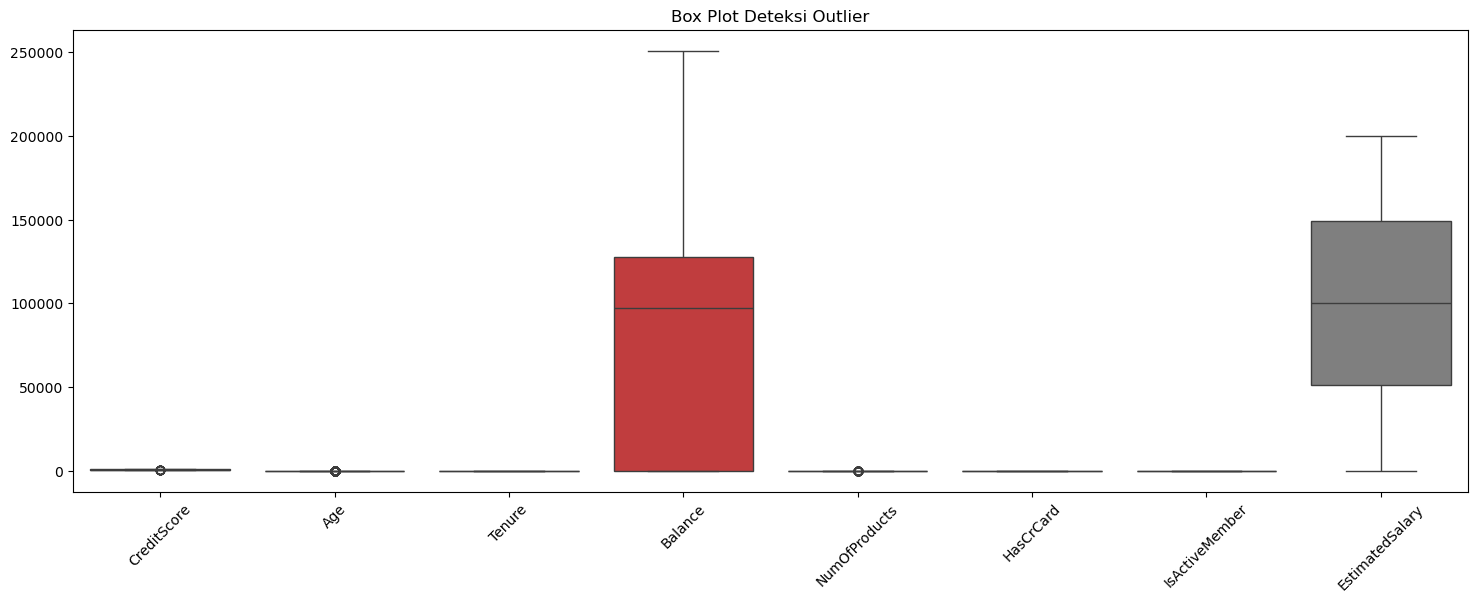

In [14]:
# Deteksi Outlier
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.figure(figsize=(18, 6))
sns.boxplot(data=df[numbers])
plt.title("Box Plot Deteksi Outlier")
plt.xticks(rotation=45)
plt.show()

In [15]:
# Hitung Q1, Q3, dan IQR untuk kolom numerik
Q1 = df[numbers].quantile(0.25)
Q3 = df[numbers].quantile(0.75)
IQR = Q3 - Q1

# Tentukan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Data sebelum:", df.shape[0], "baris")

# Hapus baris yang memiliki outlier di salah satu kolom numerik
df = df[~((df[numbers] < lower_bound) | (df[numbers] > upper_bound)).any(axis=1)]

print("Data sesudah:", df.shape[0], "baris")

Data sebelum: 10000 baris
Data sesudah: 9568 baris


In [16]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,650.690740,37.735786,5.015364,76434.055500,1.515991,0.705163,0.503658,100094.184752,0.197638
std,96.093507,8.782984,2.887869,62416.191144,0.549766,0.455993,0.500013,57522.969343,0.398238
min,383.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51014.837500,0.000000
50%,652.000000,37.000000,5.000000,97089.635000,1.000000,1.000000,1.000000,100129.330000,0.000000
75%,717.000000,43.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149461.830000,0.000000
max,850.000000,62.000000,10.000000,250898.090000,3.000000,1.000000,1.000000,199992.480000,1.000000


## 6. Pemilihan Feature

<Axes: >

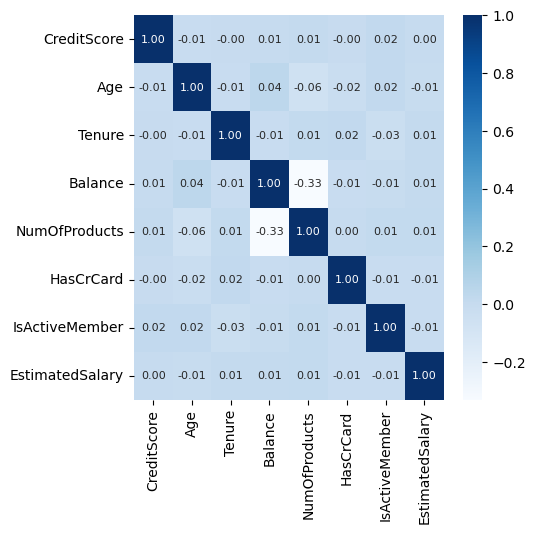

In [17]:
# Correlation Heatmap untuk melihat korelasi linear antara kolom-kolom numerik
plt.figure(figsize=(5, 5))
sns.heatmap(
    df[numbers].corr(),
    cmap='Blues',
    annot=True,
    fmt='.2f',
    annot_kws={"size": 8}
)

## 7. Unvariate Analysis

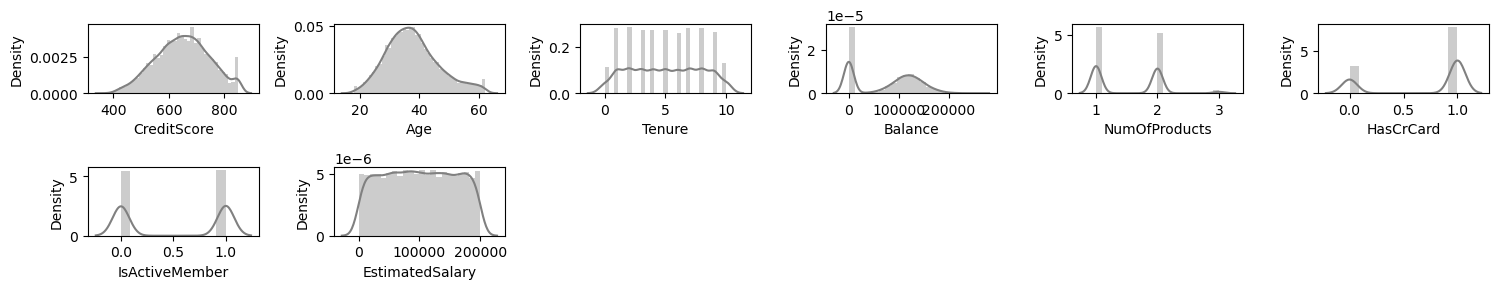

In [18]:
# Univariate Analysis dengan Density Plot
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.figure(figsize=(15, 3))

for i in range(len(numbers)):
    plt.subplot(math.ceil(len(numbers)/6), 6, i+1)
    sns.distplot(df[numbers[i]], color='gray')

plt.tight_layout()

## 8. Normalisasi dengan MinMax Scaler

In [19]:
# Menyajikan data yang telah dibersihkan
df_select = df.copy()
df_select.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [20]:
# Normalisasi kolom numerik dengan MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

for col in numbers:
    df_select[col] = MinMaxScaler().fit_transform(
        df_select[col].values.reshape(len(df_select), 1)
    )

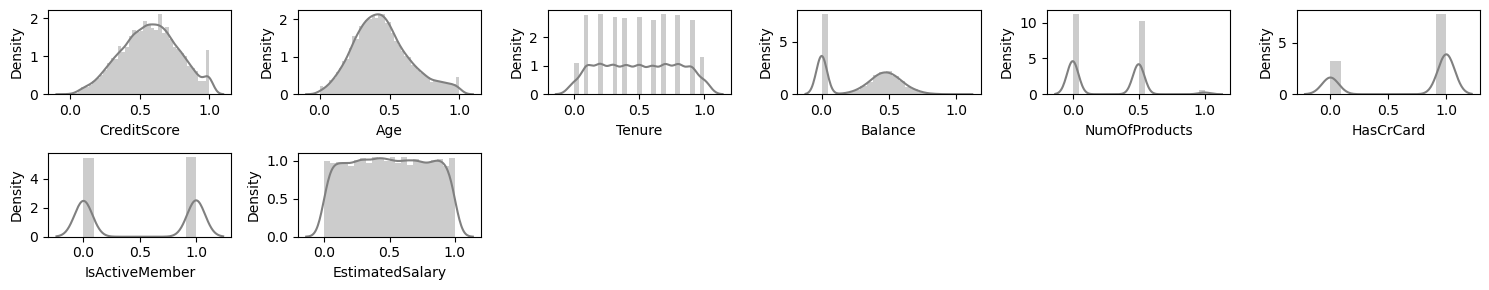

In [21]:
# Visualisasi Hasil Normalisasi dengan Density Plot
plt.figure(figsize=(15, 3))

for i in range(0, len(numbers)):
    plt.subplot(math.ceil(len(numbers)/6), 6, i+1)
    sns.distplot(df_select[numbers[i]], color='gray')

plt.tight_layout()

## 9. One-Hot Encoding

In [22]:
# One-Hot Encoding
df_select = pd.get_dummies(df_select, columns=categories)
df_select.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.505353,0.545455,0.2,0.000000,0.0,1.0,1.0,0.506735,1,True,False,False,True,False
1,0.481799,0.522727,0.1,0.334031,0.0,0.0,1.0,0.562709,0,False,False,True,True,False
2,0.254818,0.545455,0.8,0.636357,1.0,1.0,0.0,0.569654,1,True,False,False,True,False
3,0.676660,0.477273,0.1,0.000000,0.5,0.0,0.0,0.469120,0,True,False,False,True,False
4,1.000000,0.568182,0.2,0.500246,0.0,1.0,1.0,0.395400,0,False,False,True,True,False


## 10. Pembagian Variabel X dan Y

In [23]:
# Memisahkan variabel bebas (x) dan terikat (y)
X = df_select.drop("Exited", axis=1)
y = df_select["Exited"]

## 11. Train & Test Split

In [24]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi 80% untuk training dan 20% untuk testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Hasil split
print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 7654
Jumlah data test: 1914


## 12. Handle Class Imbalance

In [25]:
# Handle Class Imbalance
y.value_counts()

Exited
0    7677
1    1891
Name: count, dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_balance, y_train_balance = sm.fit_resample(X_train, y_train)

In [29]:
y_train_balance.value_counts()

Exited
0    6153
1    6153
Name: count, dtype: int64

## 13. Tuning Hyperparameter (KNN)

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Inisiasi model KNN
model_knn = KNeighborsClassifier()
param_dist = {
    'n_neighbors': range(1, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

search = RandomizedSearchCV(model_knn, param_dist, n_iter=30, cv=10, scoring='accuracy')
search.fit(X_train, y_train)

print("Best params:", search.best_params_)

Best params: {'weights': 'distance', 'n_neighbors': 12, 'metric': 'minkowski'}


## 14. Modelling

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Inisiasi model KNN
model_knn = KNeighborsClassifier(n_neighbors=13)

# Train model
model_knn.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_knn = model_knn.predict(X_test)

train_accuracy_knn = model_knn.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_knn)

Train Accuracy: 0.8482853892410206


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Inisiasi model Logistic Regression
model_logreg = LogisticRegression()

# Train model
model_logreg.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_logreg = model_logreg.predict(X_test)

train_accuracy_logreg = model_logreg.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_logreg)

Train Accuracy: 0.7291565090199903


In [33]:
from sklearn.svm import SVC

# Inisiasi model SVM
model_svm = SVC()

# Train model
model_svm.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_svm = model_svm.predict(X_test)

train_accuracy_svm = model_svm.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_svm)


Train Accuracy: 0.8055420120266537


In [34]:
from sklearn.tree import DecisionTreeClassifier

# Inisiasi model Decision Tree
model_dt = DecisionTreeClassifier()

# Train model
model_dt.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_dt = model_dt.predict(X_test)

train_accuracy_dt = model_dt.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_dt)

Train Accuracy: 1.0


In [35]:
from sklearn.ensemble import RandomForestClassifier

# Inisiasi model Random Forest
model_rf = RandomForestClassifier()

# Train model
model_rf.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_rf = model_rf.predict(X_test)

train_accuracy_rf = model_rf.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_rf)

Train Accuracy: 1.0


In [36]:
from sklearn.naive_bayes import GaussianNB

# Inisiasi model Naive Bayes
model_nb = GaussianNB()

# Train model
model_nb.fit(X_train_balance, y_train_balance)

# Prediksi menggunakan data test
y_pred_nb = model_nb.predict(X_test)

train_accuracy_nb = model_nb.score(X_train_balance, y_train_balance)
print("Train Accuracy:", train_accuracy_nb)

Train Accuracy: 0.7181862506094588


## 15. Evaluasi

In [37]:
#import metric evaluasi
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

In [38]:
# Prediksi pada data testing
y_pred_logreg = model_logreg.predict(X_test)

# Hitung metrik evaluasi
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

roc_auc_logreg = roc_auc_score(
    y_test,
    model_logreg.predict_proba(X_test)[:, 1]
)

In [39]:
# Prediksi pada data testing
y_pred_svm = model_svm.predict(X_test)

# Hitung metrik evaluasi
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

In [40]:
# Prediksi pada data testing
y_pred_dt = model_dt.predict(X_test)

# Hitung metrik evaluasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

roc_auc_dt = roc_auc_score(
    y_test,
    model_dt.predict_proba(X_test)[:, 1]
)

In [41]:
# Prediksi pada data testing
y_pred_rf = model_rf.predict(X_test)

# Hitung metrik evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

roc_auc_rf = roc_auc_score(
    y_test,
    model_rf.predict_proba(X_test)[:, 1]
)

In [42]:
# Prediksi pada data testing
y_pred_knn = model_knn.predict(X_test)

# Hitung metrik evaluasi
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

roc_auc_knn = roc_auc_score(
    y_test,
    model_knn.predict_proba(X_test)[:, 1]
)

In [43]:
# Prediksi pada data testing
y_pred_nb = model_nb.predict(X_test)

# Hitung metrik evaluasi
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

cm_nb = confusion_matrix(y_test, y_pred_nb)

roc_auc_nb = roc_auc_score(
    y_test,
    model_nb.predict_proba(X_test)[:, 1]
)

In [44]:
df_evaluasi = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'Decision Tree', 'Random Forest',
        'Support Vector Machine', 'K-Nearest Neighbor', 
        'Naive-Bayes'],
    'Akurasi': [
        accuracy_logreg, accuracy_dt, accuracy_rf, accuracy_svm,
        accuracy_knn, accuracy_nb],
    'Precision': [
        precision_logreg, precision_dt, precision_rf,
        precision_svm, precision_knn,precision_nb],
    'Recall': [
        recall_logreg, recall_dt, recall_rf,
        recall_svm, recall_knn, recall_nb],
    'F1 Score': [
        f1_logreg, f1_dt, f1_rf,
        f1_svm, f1_knn, f1_nb]
})

df_evaluasi.round(3)

,Model,Akurasi,Precision,Recall,F1 Score
0,Logistic Regression,0.734,0.412,0.715,0.523
1,Decision Tree,0.776,0.460,0.564,0.507
2,Random Forest,0.821,0.558,0.579,0.569
3,Support Vector Machine,0.769,0.457,0.721,0.559
4,K-Nearest Neighbor,0.735,0.412,0.703,0.519
5,Naive-Bayes,0.726,0.405,0.736,0.523


In [45]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_nb = confusion_matrix(y_test, y_pred_nb)

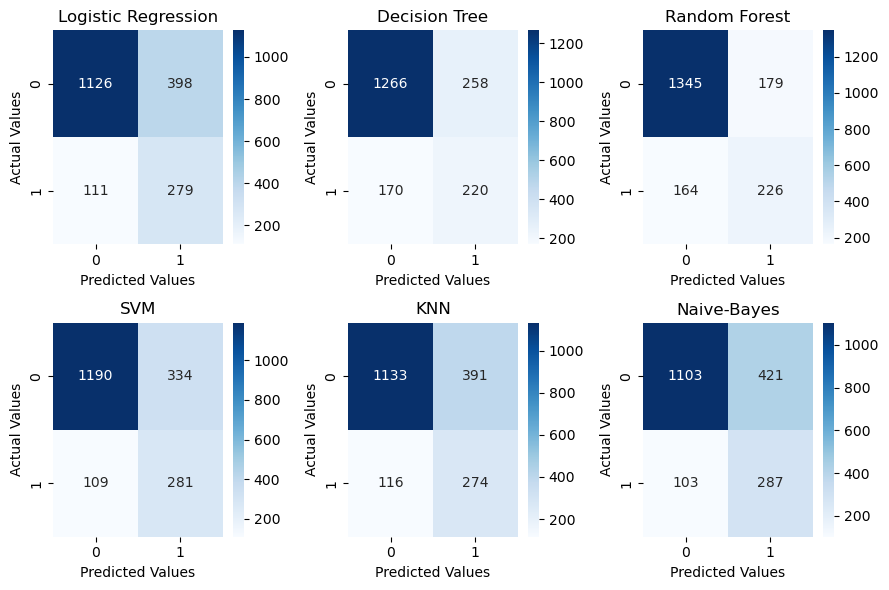

In [46]:
cm_list = [cm_logreg, cm_dt, cm_rf, cm_svm, cm_knn, cm_nb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest',
               'SVM', 'KNN', 'Naive-Bayes']
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(len(cm_list)):
    row = i // 3
    col = i % 3
    sns.heatmap(cm_list[i], annot=True, cmap='Blues', fmt='g', ax=axes[row, col])
    axes[row, col].set_title(model_names[i])
    axes[row, col].set_ylabel('Actual Values')
    axes[row, col].set_xlabel('Predicted Values')
plt.tight_layout()
plt.show()